# 图像分类（基于卷积神经网络）

参考 [tensorflow 官方文档](https://tensorflow.google.cn/tutorials/images/classification)，支持直接从文件夹中读取数据集，解决过拟合方法，数据增强等操作.

一个基本的神经网络工作流程可以分为如下六步：
1. 校验和理解数据集.
2. 建立输入流.（将训练集和验证集存入tf.dataset）
3. 建立模型.
4. 训练模型.
5. 测试模型.
6. 改进模型.

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

## 下载数据集
通过该url会下载一个压缩包，使用 [`keras.utils.get_file(fname, origin, untar)`](https://tensorflow.google.cn/api_docs/python/tf/keras/utils/get_file) 可以对下载的压缩包进行解压，返回下载文件的目录.

这里用到一个Python3.4后自带的包 `pathlib`，可以根据文件路径进行文件处理操作，有以下一些常用操作：

- `pathlib.Path(directory)`：`directory` 为文件的路径，返回 `pathlib.Path` 对象，该对象存储的为 `directory` 这条路径.

- `pathlib.Path.cwd()`：cwd为Current working directory的缩写，即返回当前运行程序所在的目录.

- `pathlib.Path.glob(pattern)`：`pattern` 可以是一个正则表达式(regex)，则该函数会返回该路径下所有符合该 `pattern` 的文件路径. 如 `*.py` 就会返回全体以 `.py` 为后缀的文件，`*` 可以理解为任一的一个前缀（文件名）.

In [2]:
import pathlib  # 用于文件路径的各种操作
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
dataset_dir = keras.utils.get_file('flower_photos', dataset_url, untar=True)
dataset_dir = pathlib.Path(dataset_dir)
print('文件保存地址为：{}'.format(dataset_dir))

文件保存地址为：/root/.keras/datasets/flower_photos


In [3]:
total = len(list(dataset_dir.glob('*/*.jpg')))
print('图片总数：{}'.format(total))

图片总数：3670


## 构建数据集

使用 [`tf.keras.utils.image_dataset_from_directory`](https://tensorflow.google.cn/api_docs/python/tf/keras/utils/image_dataset_from_directory) 从文件夹中直接读取数据集，可划分出训练集和验证集，同时还能将图片大小进行统一，要求文件夹训练数据满足一下要求：

```
dataset/
    class1/
        1.jpg
        11.jpg
        111.jpg
    class2/
        2.jpg
        22.jpg
        222.jpg
    .../
```

按子文件夹的名称的字典序从小到大，将标签分别记为 `0,1,2,...`，每个子文件夹下的文件为对应标签下的特征.

在这个数据集中，花朵编号为：

0. daisy  雏菊
1. dandelion  蒲公英
2. roses  玫瑰
3. sunflowers  向日葵
4. tulips  郁金香

In [4]:
train = keras.utils.image_dataset_from_directory(
    dataset_dir,  # 数据集的文件夹
    batch_size=32,  # batch size大小
    image_size=(180, 180),  # 统一图片大小，可将数据集中的图片进行缩放为该大小
    seed=19260817,  # 随机种子（由于要划分出训练集和验证集，且分别赋值，所以要确定种子，避免划分出现重复）
    validation_split=0.2,  # 验证集划分比例 20%
    subset='training'  # 取出训练集
)
test = keras.utils.image_dataset_from_directory(
    dataset_dir,
    batch_size=32,
    image_size=(180, 180),
    seed=19260817,
    validation_split=0.2,
    subset='validation'  # 取出验证集
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [5]:
classes = train.class_names
print('类别：', classes)

类别： ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


训练集大小：(32, 180, 180, 3)，验证集大小：(32,)


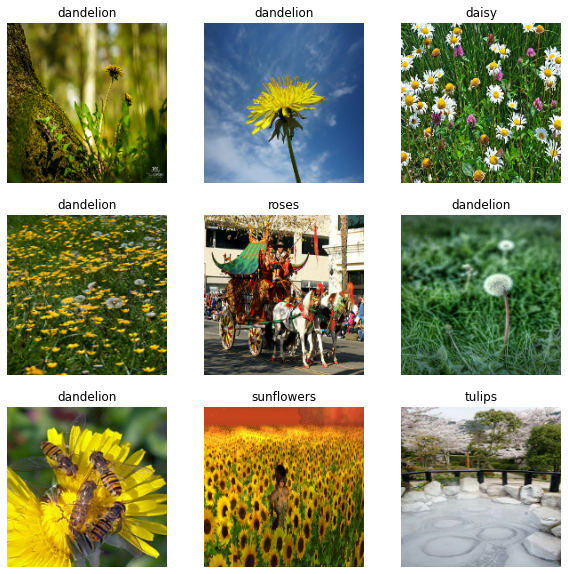

In [6]:
for x, y in train:
    print('训练集大小：{}，验证集大小：{}'.format(x.shape, y.shape))
    fig = plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(np.array(x[i]).astype(np.uint8))
        plt.title(classes[y[i]])
        plt.axis('off')
    plt.show()
    break

## 配置数据（提高性能）

- [`Dataset.cashe`](https://tensorflow.google.cn/api_docs/python/tf/data/Dataset#cache) 在第一个epoch从磁盘读取数据后，将数据存入内存中，提高速度. 如果数据集太大，可以通过该方法创建高性能磁盘缓存.

- [`Dataset.prefetch`](https://tensorflow.google.cn/api_docs/python/tf/data/Dataset#cache) 在训练模型时预处理数据的大小.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().shuffle(1000).prefetch(AUTOTUNE)
test = test.cache().prefetch(AUTOTUNE)

### 归一化数据

图像的RGB通道值是 $[0, 255]$ 范围的，为了提高训练效率（提高梯度更新速度），将数据进行归一化处理，统一除以 $256$，使得特征值在 $[0,1)$ 之间.

- [`tf.keras.layers.Recaling(scale, offset=0.0)`](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/Rescaling)，将输入特征进行按比例 `scale` 进行整体调整，`offset` 为整体偏移量. 如果令输入特征为 $x$，则调整后为 $x * \mathtt{scale} + \mathtt{offset}$.

- [`tf.data.Dataset.map(map_func)`](https://tensorflow.google.cn/api_docs/python/tf/data/Dataset#map)，对该数据集中的每个元素应用 `map_func` 函数.（在建立模型的时候可以直接将 `layers.Rescaling` 作为一层直接置于模型中，更加方便）

In [8]:
normal_layer = layers.Rescaling(1/256)
normal_ds = train.map(lambda x, y: (normal_layer(x), y))
x, y = list(normal_ds)[0]
print('特征范围：[{}, {}]'.format(np.min(x), np.max(x)))

特征范围：[0.0, 0.99609375]


## CNN 架构

简单的CNN是由卷积层（Conv），汇聚层（Pooling）和全连接层（Denes），下面我们开始构建卷积神经网络的架构.

### 卷积块&全连接层

以下是构建卷积块所需的api操作.

- `tf.keras.layers.Conv2D(filters, kernel_size, activation=None, padding='valid', input_shape)`：创建一个二维卷积层，`filters`为卷积核的深度，即输出的特征映射的个数；`kernel_size`为卷积核的大小；`activation`为激活函数（默认为空）；`padding`为是否补零，即等宽卷积还是普通卷积，默认为普通卷积，`padding='same'`为等宽卷积；`input_shape`为输入的特征映射的维度（只需在第一层进行设定）.

- `tf.keras.layers.MaxPool2D(pool_szie=(2, 2))`：创建一个二维汇聚层，其中`pool_size`为汇聚所划分的每个区域的大小（默认为`(2,2)`）.

- `model.add(layers)`：`layers`为`tf.keras.layers`类，如果`model`为`Sequential()`类，则在`model`的尾部再加入一层`layers`.

- `model.summary()`：显示模型的结构，包括总参数个数，输出数据大小.

In [9]:
model = keras.Sequential([
    layers.Rescaling(1/256, input_shape=(180, 180, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(classes), activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [10]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


## 训练模型

In [11]:
history = model.fit(train, validation_data=test, epochs=10)

Epoch 1/10
92/92 [==============================] - 99s 1s/step - loss: 1.3847 - accuracy: 0.3927 - val_loss: 1.2434 - val_accuracy: 0.4796
Epoch 2/10
92/92 [==============================] - 93s 1s/step - loss: 1.0714 - accuracy: 0.5719 - val_loss: 0.9868 - val_accuracy: 0.6226
Epoch 3/10
92/92 [==============================] - 92s 996ms/step - loss: 0.8827 - accuracy: 0.6591 - val_loss: 0.9613 - val_accuracy: 0.6185
Epoch 4/10
92/92 [==============================] - 93s 1s/step - loss: 0.7187 - accuracy: 0.7299 - val_loss: 0.9485 - val_accuracy: 0.6580
Epoch 5/10
92/92 [==============================] - 93s 1s/step - loss: 0.5746 - accuracy: 0.7888 - val_loss: 0.8828 - val_accuracy: 0.6689
Epoch 6/10
92/92 [==============================] - 93s 1s/step - loss: 0.4030 - accuracy: 0.8614 - val_loss: 1.0542 - val_accuracy: 0.6458
Epoch 7/10
92/92 [==============================] - 94s 1s/step - loss: 0.2628 - accuracy: 0.9135 - val_loss: 1.1594 - val_accuracy: 0.6580
Epoch 8/10
92/92 

## 可视化训练结果

利用训练返回的 `history` 可以查看每次训练结果的 `loss` 和 `accuracy` 对应的value值，从而绘制图像.

- `history.history`：返回一个字典，存储训练过程中每次更新的结果.

- `history.params`：返回训练所用到的参数.

In [18]:
print('key值：', history.history.keys())

print('训练参数：', history.params)

def plot_history(history):
    x = range(history.params['epochs'])
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, label='Training Accuracy')
    plt.plot(x, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, label='Training Loss')
    plt.plot(x, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


key值： dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
训练参数： {'verbose': 1, 'epochs': 15, 'steps': 92}


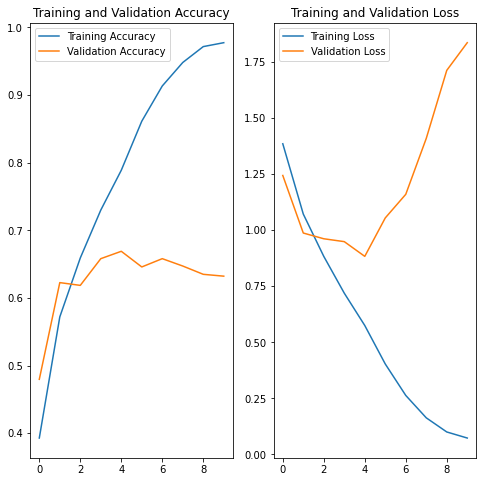

In [13]:
plot_history(history)

从上图中可以清晰地看出，该模型出现了过拟合现象，训练集的loss保持下降，但验证集的loss反而上升，而且验证集准确率一直很低. 可以通过加入 `dropout` 和数据增强（data augmentation）优化模型.

## 模型优化

### 数据增强

考虑将一张图片进行旋转，平移，伸缩等操作，可以得到类似的更多的图片，tensorflow可以通过加入数据增强层，对数据进行预处理操作. 主要使用以下6种操作：

下述api中大多都有一个名为 `factor` 的变量，表示该操作的比例大小，有两种输入形式：

1. 单独一个浮点数 `x` ，表示该操作变化比例在 `[-x, x]` 范围内随机取值. 例如：旋转操作中是 $[-x\cdot 2\pi, x\cdot 2\pi]$ 范围内取旋转角度.

2. 一个包含两个浮点数的 tuple：`(x, y)`，表示该操作变化比例在 `[x, y]` 范围内随机取值. 例如：旋转操作是在 $[x\cdot 2\pi, y\cdot 2\pi]$ 范围内取旋转角度.

最后两个api中包含参数 `fill_mode` 表示对空白处进行填充的方法，有 $4$ 种方法：

- `reflect`（反射）：通过反射最后一个像素的边缘进行填充. 如：(d c b a | a b c d | d c b a)

- `constant`（常数）：使用零填充. 如：(k k k k | a b c d | k k k k)，其中 k=0

- `wrap`（环绕）：通过环绕到相对边缘进行填充. 如：(a b c d | a b c d | a b c d)

- `nearest`（邻近）：通过最近的像素进行填充. 如：(a a a a | a b c d | d d d d)

注：有一些操作 `factor` 只能取正数；下述api中还有一个 `seed` 的操作，用于设定随机种子.

- `tf.keras.layers.RandomRotation(factor)`：旋转操作，`factor` 正数为逆时针，负数为顺指针.

- `tf.keras.layers.RandomHeight(factor)`：竖向压缩图片，`factor`正数为拉伸，负数为压缩，该操作会将图片的尺寸修改.

- `tf.keras.layers.RandomWidth(factor)`：横向压缩图片，`factor`正数为拉伸，负数为压缩，该操作会将图片的尺寸修改.

- `tf.keras.layers.RandomFlip(mode='horizontal_and_vertical')`：沿水平和竖直方向翻折图片，`mode` 为旋转模式，有三种选项：`horizontal`, `vertical`, `horizontal_and_vertical` 分别表示：只进行横向翻折，只沿竖向翻折，两者都有可能. 默认为第三个选项.

- `tf.keras.layers.RandomZoom(height_factor, width_factor=None, fill_mode='reflect')`：缩放操作，`factor` 正数为缩小，负数为放大，如果只设置第一个参数 `height_factor`，则保持横纵比不变的缩放操作；若设定 `width_factor` 则进行横纵比变化的缩放操作.

- `tf.keras.layers.RandomTranslation(height_factor, width_factor, fill_mode='reflect')`：平移操作，`factor` 正数为向下和向右，负数为向上和向左（分别对应 `height_factor`, `width_factor`）.


这里通过旋转和左右反转操作，对数据进行增强，即将一张图片进行不同的变化，从而加强数据.

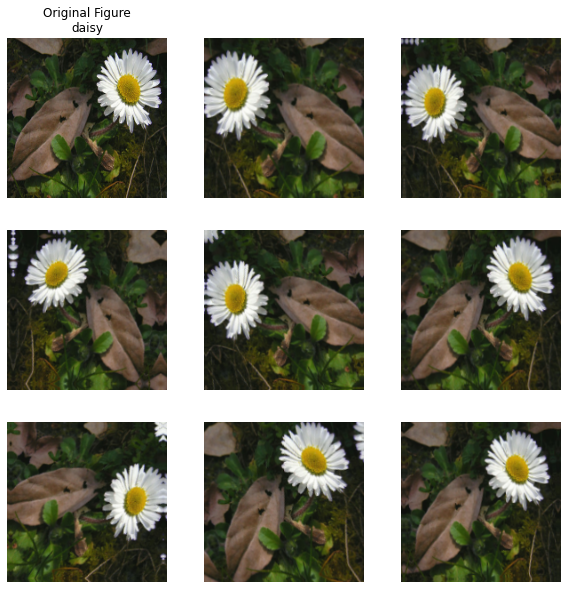

In [14]:
augmentation = keras.Sequential([
    layers.RandomFlip('horizontal', input_shape=(180, 180, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])
# 下面查看一下数据增强的效果
plt.figure(figsize=(10, 10))
for x, y in train:
    plt.subplot(3, 3, 1)
    plt.imshow(x[0].numpy().astype(np.uint8))
    plt.title('Original Figure\n' + classes[y[0]])
    plt.axis('off')
    for i in range(8):
        plt.subplot(3, 3, i+2)
        plt.imshow(augmentation(x)[0].numpy().astype(np.uint8))
        plt.axis('off')
    break
plt.show()

### Dropout（随机丢弃神经元输出）

为了避免过拟合，可以使用dropout使得每次迭代过程中，将部分神经元的输出丢弃（设置为0），可以提高正则化强度. 在模型中通过加入 [`tf.keras.layers.Dropout(rate)`](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/Dropout) 实现该操作，其中 `rate` 为丢弃率，即输入特征中有 `rate` 比例个元素会被设置为0.


In [15]:
model = keras.Sequential([
    augmentation,  # 数据增强
    layers.Rescaling(1/256, input_shape=(180, 180, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.2),  # Dropout
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(classes), activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [16]:
history = model.fit(train, validation_data=test, epochs=15)

Epoch 1/15
92/92 [==============================] - 109s 1s/step - loss: 1.4391 - accuracy: 0.3491 - val_loss: 1.1602 - val_accuracy: 0.5245
Epoch 2/15
92/92 [==============================] - 107s 1s/step - loss: 1.0949 - accuracy: 0.5603 - val_loss: 1.2942 - val_accuracy: 0.4986
Epoch 3/15
92/92 [==============================] - 108s 1s/step - loss: 0.9825 - accuracy: 0.6008 - val_loss: 0.9622 - val_accuracy: 0.6362
Epoch 4/15
92/92 [==============================] - 107s 1s/step - loss: 0.8996 - accuracy: 0.6495 - val_loss: 0.9244 - val_accuracy: 0.6512
Epoch 5/15
92/92 [==============================] - 108s 1s/step - loss: 0.8364 - accuracy: 0.6788 - val_loss: 0.8466 - val_accuracy: 0.6649
Epoch 6/15
92/92 [==============================] - 107s 1s/step - loss: 0.7866 - accuracy: 0.6931 - val_loss: 0.9166 - val_accuracy: 0.6676
Epoch 7/15
92/92 [==============================] - 107s 1s/step - loss: 0.7482 - accuracy: 0.7146 - val_loss: 0.7807 - val_accuracy: 0.7084
Epoch 8/15
92

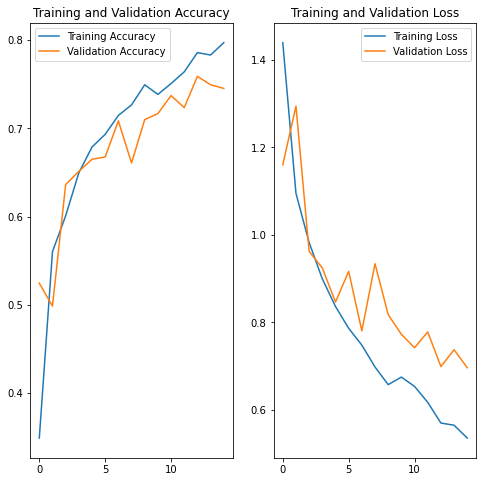

In [19]:
plot_history(history)

可以看出加入正则化参数后，验证集上正确率提高了不少，效果还是很好的.

### 预测数据

首先看下预测错误的图像有哪些.

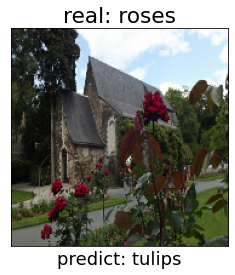

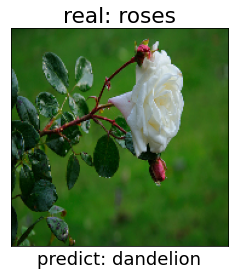

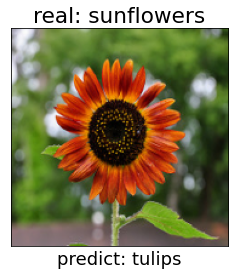

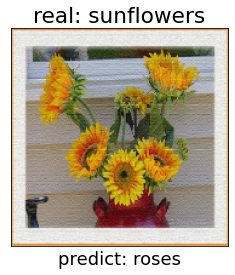

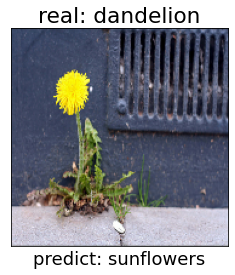

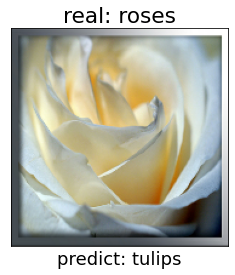

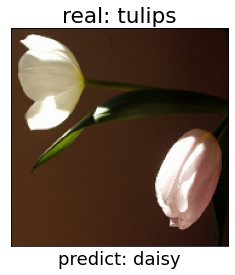

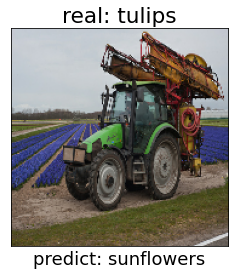

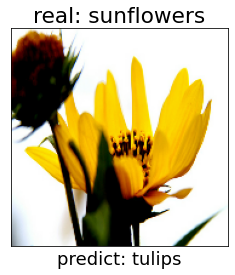

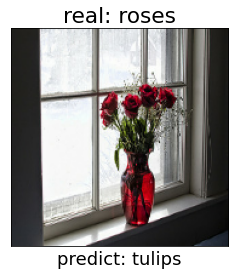

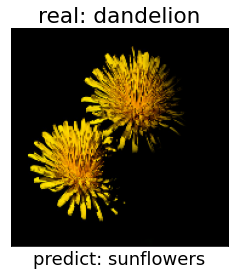

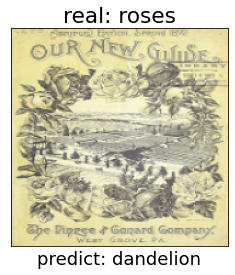

In [20]:
check_total = 12  # 输出check_total张预测错误的图片

plt.rcParams['font.size']=18
for x, y in test:
    batch_size = x.shape[0]
    for i in range(batch_size):
        if check_total == 0:
            break
        predict = list(model.predict(np.array([x[i]])))
        pred_idx = np.argmax(predict)
        if y[i] != pred_idx:
            check_total -= 1
            plt.imshow(np.array(x[i]).astype(np.uint8))
            plt.xlabel('predict: ' + classes[pred_idx])
            plt.title('real: ' + classes[y[i]])
            plt.xticks([])
            plt.yticks([])
            plt.show()
    if check_total == 0:
        break

预测为sunflowers, 置信度: 89.01965618133545%


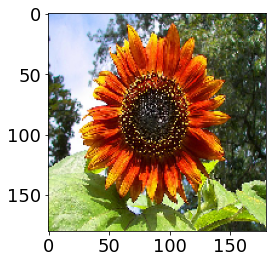

In [21]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(  # 读取为Image类
    sunflower_path,
    target_size=(180, 180)
)
img = tf.keras.utils.img_to_array(img)  # 转化为ndarry
img = np.array([img])

predict = model.predict(img)[0]
pred_idx = np.argmax(predict)
print('预测为{}, 置信度: {}%'.format(classes[pred_idx], (predict / np.sum(predict))[pred_idx] * 100))
plt.imshow(img[0].astype(np.uint8))
plt.show()